<a href="https://colab.research.google.com/github/AyeshaCrystal/FoodApp-Redesign/blob/main/Ayesha_Farhunnisa_J(Project).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# =============================================================================
# STEP 1: INSTALL ALL REQUIRED LIBRARIES
# =============================================================================

!pip install pandas numpy matplotlib seaborn scikit-learn nltk wordcloud textblob
!pip install transformers torch datasets plotly
!pip install flask-ngrok pyngrok
!pip install streamlit streamlit-ace
!pip install joblib imbalanced-learn

# Download NLTK data
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('punkt_tab') # Download the missing resource

print("✅ All libraries installed successfully!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 61.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 83.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 111.6 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...


✅ All libraries installed successfully!


[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [2]:
# =============================================================================
# STEP 2: IMPORT ALL LIBRARIES
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import warnings
warnings.filterwarnings('ignore')

# NLP Libraries
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Machine Learning
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, roc_curve
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE

# Deep Learning & GenAI
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline
from datasets import Dataset

# Visualization
from wordcloud import WordCloud
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Deployment
import joblib
from google.colab import files
import io

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


In [3]:
# =============================================================================
# STEP 3: LOAD AND EXPLORE DATASET
# =============================================================================

# Method 1: Load from GitHub (Recommended)
import requests

url = "https://raw.githubusercontent.com/justmarkham/DAT8/master/data/sms.tsv"
response = requests.get(url)
data = pd.read_csv(io.StringIO(response.text), sep='\t', header=None, names=['label', 'message'])

print("📊 Dataset Overview:")
print(f"Dataset shape: {data.shape}")
print(f"Spam messages: {len(data[data['label']=='spam'])}")
print(f"Ham messages: {len(data[data['label']=='ham'])}")

# Display first few rows
print("\nFirst 5 messages:")
print(data.head())

# Label distribution
print("\nLabel Distribution:")
print(data['label'].value_counts())

📊 Dataset Overview:
Dataset shape: (5572, 2)
Spam messages: 747
Ham messages: 4825

First 5 messages:
  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...

Label Distribution:
label
ham     4825
spam     747
Name: count, dtype: int64


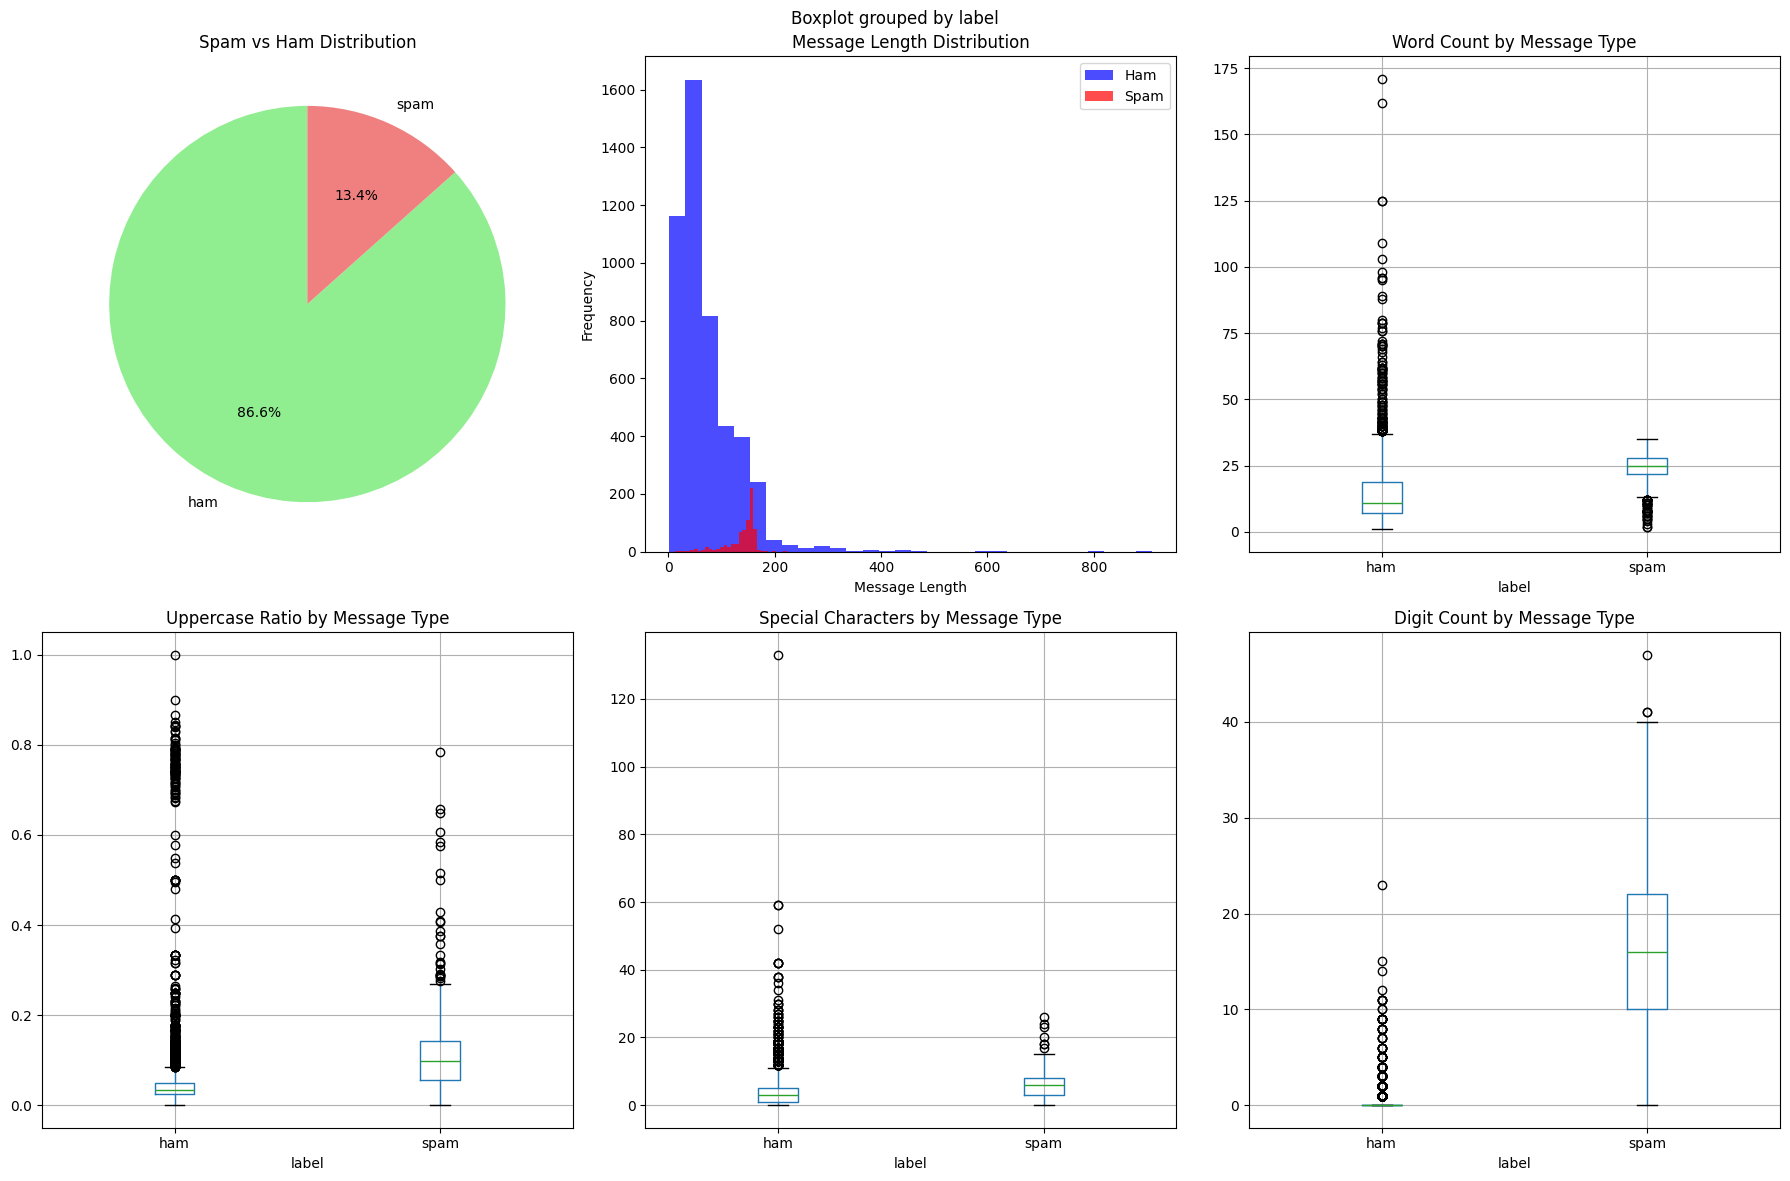


📈 Statistical Summary:
      message_length                     word_count                      \
                mean        std min  max       mean        std min  max   
label                                                                     
ham        71.482487  58.440652   2  910  14.310259  11.517945   1  171   
spam      138.670683  28.873603  13  223  23.911647   5.780174   2   35   

      uppercase_ratio           digit_count            
                 mean       std        mean       std  
label                                                  
ham          0.058464  0.110678    0.305285  1.073319  
spam         0.110913  0.085283   15.812584  8.720239  


In [4]:
# =============================================================================
# STEP 4: COMPREHENSIVE EDA
# =============================================================================

# Create a detailed EDA function
def perform_eda(data):
    # Create subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # 1. Label distribution pie chart
    label_counts = data['label'].value_counts()
    axes[0,0].pie(label_counts.values, labels=label_counts.index, autopct='%1.1f%%',
                  colors=['lightgreen', 'lightcoral'], startangle=90)
    axes[0,0].set_title('Spam vs Ham Distribution')

    # 2. Message length analysis
    data['message_length'] = data['message'].apply(len)
    data['word_count'] = data['message'].apply(lambda x: len(x.split()))

    # Ham vs Spam length distribution
    axes[0,1].hist(data[data['label']=='ham']['message_length'], alpha=0.7,
                   label='Ham', color='blue', bins=30)
    axes[0,1].hist(data[data['label']=='spam']['message_length'], alpha=0.7,
                   label='Spam', color='red', bins=30)
    axes[0,1].set_title('Message Length Distribution')
    axes[0,1].set_xlabel('Message Length')
    axes[0,1].set_ylabel('Frequency')
    axes[0,1].legend()

    # 3. Word count box plot
    data.boxplot(column='word_count', by='label', ax=axes[0,2])
    axes[0,2].set_title('Word Count by Message Type')

    # 4. Uppercase ratio analysis
    data['uppercase_ratio'] = data['message'].apply(
        lambda x: sum(1 for c in x if c.isupper()) / len(x) if len(x) > 0 else 0
    )
    data.boxplot(column='uppercase_ratio', by='label', ax=axes[1,0])
    axes[1,0].set_title('Uppercase Ratio by Message Type')

    # 5. Special characters count
    data['special_chars'] = data['message'].apply(
        lambda x: sum(1 for c in x if not c.isalnum() and not c.isspace())
    )
    data.boxplot(column='special_chars', by='label', ax=axes[1,1])
    axes[1,1].set_title('Special Characters by Message Type')

    # 6. Digit count
    data['digit_count'] = data['message'].apply(
        lambda x: sum(1 for c in x if c.isdigit())
    )
    data.boxplot(column='digit_count', by='label', ax=axes[1,2])
    axes[1,2].set_title('Digit Count by Message Type')

    plt.tight_layout()
    plt.show()

    return data

# Perform EDA
data = perform_eda(data)

# Display statistical summary
print("\n📈 Statistical Summary:")
print(data.groupby('label').agg({
    'message_length': ['mean', 'std', 'min', 'max'],
    'word_count': ['mean', 'std', 'min', 'max'],
    'uppercase_ratio': ['mean', 'std'],
    'digit_count': ['mean', 'std']
}))

In [5]:
# =============================================================================
# STEP 5: GENAI-ENHANCED TEXT PREPROCESSING
# =============================================================================

from nltk.tokenize import PunktTokenizer

class AdvancedTextPreprocessor:
    def __init__(self):
        self.stemmer = PorterStemmer()
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))
        self.tokenizer = PunktTokenizer() # Initialize PunktTokenizer here

        # Common spam words for feature engineering
        self.spam_keywords = ['free', 'win', 'prize', 'cash', 'urgent', 'click',
                             'offer', 'guaranteed', 'winner', 'congratulations',
                             'selected', 'award', 'claim', 'now', 'limited']

    def clean_text(self, text):
        """Advanced text cleaning with spam-specific patterns"""
        # Convert to lowercase
        text = text.lower()

        # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

        # Remove email addresses
        text = re.sub(r'\S+@\S+', '', text)

        # Remove phone numbers (international formats)
        text = re.sub(r'[\+\(]?[1-9][0-9 .\-\(\)]{8,}[0-9]', '', text)

        # Remove special characters but keep basic punctuation for context
        text = re.sub(r'[^\w\s]', ' ', text)

        # Remove extra whitespace
        text = ' '.join(text.split())

        return text

    def tokenize_and_stem(self, text):
        """Tokenization with spam-aware processing"""
        # Use the initialized PunktTokenizer
        tokens = self.tokenizer.tokenize(text)

        # Remove stopwords and short tokens, but keep spam indicators
        tokens = [token for token in tokens
                 if (token not in self.stop_words or token in self.spam_keywords)
                 and len(token) > 2]

        # Apply stemming
        stems = [self.stemmer.stem(token) for token in tokens]
        return ' '.join(stems)

    def extract_features(self, text):
        """Extract advanced features for model training"""
        features = {}

        # Basic text features
        features['length'] = len(text)
        features['word_count'] = len(text.split())
        features['char_count'] = len(text.replace(" ", ""))
        features['avg_word_length'] = features['char_count'] / features['word_count'] if features['word_count'] > 0 else 0

        # Complexity features
        features['unique_words'] = len(set(text.split()))
        features['lexical_diversity'] = features['unique_words'] / features['word_count'] if features['word_count'] > 0 else 0

        # Structural features
        features['uppercase_count'] = sum(1 for c in text if c.isupper())
        features['digit_count'] = sum(1 for c in text if c.isdigit())
        features['special_char_count'] = sum(1 for c in text if not c.isalnum() and not c.isspace())

        # Spam-specific features
        features['spam_keyword_count'] = sum(1 for word in text.split() if word in self.spam_keywords)
        features['spam_keyword_ratio'] = features['spam_keyword_count'] / features['word_count'] if features['word_count'] > 0 else 0

        # Urgency indicators
        urgency_words = ['urgent', 'immediately', 'now', 'limited', 'expires']
        features['urgency_count'] = sum(1 for word in text.split() if word in urgency_words)

        return features

    def preprocess_pipeline(self, text):
        """Complete preprocessing pipeline"""
        text = self.clean_text(text)
        text = self.tokenize_and_stem(text)
        return text

# Initialize and test preprocessor
print("🔄 Initializing Advanced Text Preprocessor...")
preprocessor = AdvancedTextPreprocessor()

# Test preprocessing
sample_message = "Congratulations! You've WON a $1000 Walmart Gift Card. TEXT NOW to claim! http://win.com"
cleaned = preprocessor.preprocess_pipeline(sample_message)
features = preprocessor.extract_features(sample_message)

print("✅ Preprocessor Test:")
print(f"Original: {sample_message}")
print(f"Cleaned: {cleaned}")
print(f"Features: {features}")

# Apply preprocessing to entire dataset
print("\n🔄 Processing entire dataset...")
data['cleaned_message'] = data['message'].apply(preprocessor.preprocess_pipeline)

# Extract features for all messages
print("🔄 Extracting advanced features...")
feature_data = []
for message in data['message']:
    feature_data.append(preprocessor.extract_features(message))

feature_df = pd.DataFrame(feature_data)
data_with_features = pd.concat([data, feature_df], axis=1)

print(f"✅ Feature extraction complete! Added {len(feature_df.columns)} advanced features")

🔄 Initializing Advanced Text Preprocessor...
✅ Preprocessor Test:
Original: Congratulations! You've WON a $1000 Walmart Gift Card. TEXT NOW to claim! http://win.com
Cleaned: congratulations you ve won a 1000 walmart gift card text now to claim
Features: {'length': 88, 'word_count': 13, 'char_count': 76, 'avg_word_length': 5.846153846153846, 'unique_words': 13, 'lexical_diversity': 1.0, 'uppercase_count': 15, 'digit_count': 4, 'special_char_count': 9, 'spam_keyword_count': 0, 'spam_keyword_ratio': 0.0, 'urgency_count': 0}

🔄 Processing entire dataset...
🔄 Extracting advanced features...
✅ Feature extraction complete! Added 12 advanced features


📊 Generating Word Clouds...


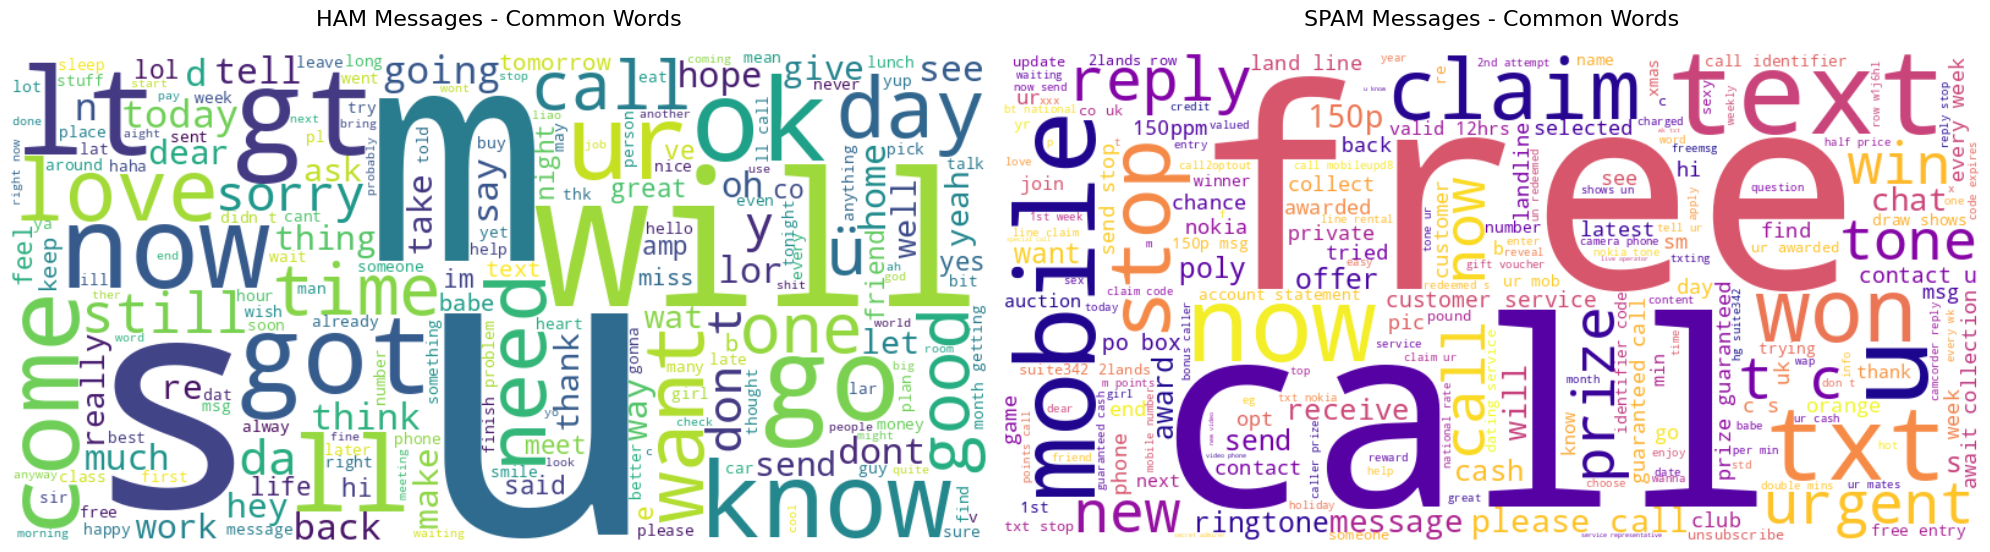

📈 Creating Interactive Charts...


🔥 Creating Correlation Heatmap...


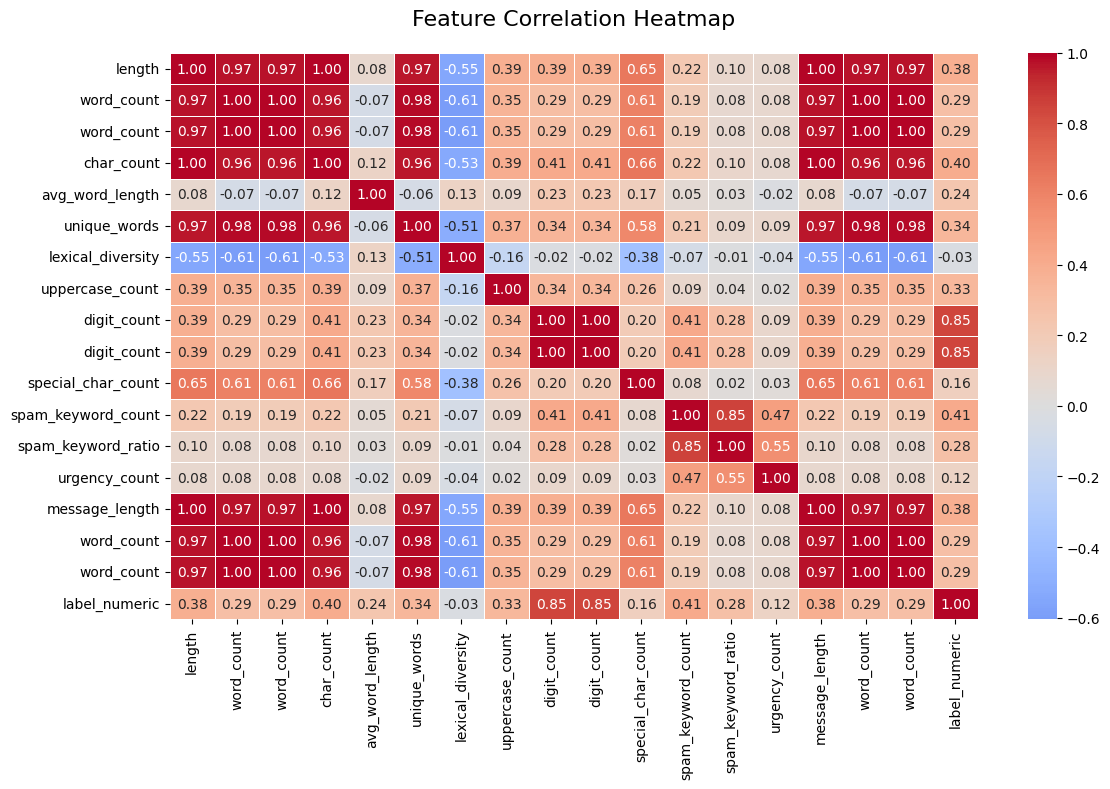

In [6]:
# =============================================================================
# STEP 6: ADVANCED VISUALIZATION
# =============================================================================

def create_advanced_visualizations(data):
    """Create comprehensive visualizations for spam analysis"""

    # 1. Word Clouds
    print("📊 Generating Word Clouds...")
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))

    # Ham word cloud
    ham_text = ' '.join(data[data['label']=='ham']['cleaned_message'])
    wordcloud_ham = WordCloud(width=800, height=400, background_color='white',
                             colormap='viridis').generate(ham_text)
    axes[0].imshow(wordcloud_ham, interpolation='bilinear')
    axes[0].set_title('HAM Messages - Common Words', fontsize=16, pad=20)
    axes[0].axis('off')

    # Spam word cloud
    spam_text = ' '.join(data[data['label']=='spam']['cleaned_message'])
    wordcloud_spam = WordCloud(width=800, height=400, background_color='white',
                              colormap='plasma').generate(spam_text)
    axes[1].imshow(wordcloud_spam, interpolation='bilinear')
    axes[1].set_title('SPAM Messages - Common Words', fontsize=16, pad=20)
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

    # 2. Interactive Plotly Visualizations
    print("📈 Creating Interactive Charts...")

    # Feature comparison
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=('Message Length by Type', 'Spam Keyword Frequency',
                       'Uppercase Ratio Distribution', 'Digit Count Analysis'),
        specs=[[{"type": "box"}, {"type": "box"}],
               [{"type": "box"}, {"type": "box"}]]
    )

    # Message length
    fig.add_trace(go.Box(y=data[data['label']=='ham']['message_length'],
                        name='Ham', marker_color='lightblue'), row=1, col=1)
    fig.add_trace(go.Box(y=data[data['label']=='spam']['message_length'],
                        name='Spam', marker_color='lightcoral'), row=1, col=1)

    # Spam keywords
    fig.add_trace(go.Box(y=data[data['label']=='ham']['spam_keyword_count'],
                        name='Ham', marker_color='lightblue', showlegend=False), row=1, col=2)
    fig.add_trace(go.Box(y=data[data['label']=='spam']['spam_keyword_count'],
                        name='Spam', marker_color='lightcoral', showlegend=False), row=1, col=2)

    # Uppercase ratio
    fig.add_trace(go.Box(y=data[data['label']=='ham']['uppercase_ratio'],
                        name='Ham', marker_color='lightblue', showlegend=False), row=2, col=1)
    fig.add_trace(go.Box(y=data[data['label']=='spam']['uppercase_ratio'],
                        name='Spam', marker_color='lightcoral', showlegend=False), row=2, col=1)

    # Digit count
    fig.add_trace(go.Box(y=data[data['label']=='ham']['digit_count'],
                        name='Ham', marker_color='lightblue', showlegend=False), row=2, col=2)
    fig.add_trace(go.Box(y=data[data['label']=='spam']['digit_count'],
                        name='Spam', marker_color='lightcoral', showlegend=False), row=2, col=2)

    fig.update_layout(height=800, title_text="Advanced Feature Analysis - Spam vs Ham",
                     template="plotly_white")
    fig.show()

    # 3. Correlation Heatmap
    print("🔥 Creating Correlation Heatmap...")
    numeric_features = feature_df.select_dtypes(include=[np.number]).columns
    correlation_data = data_with_features[numeric_features.tolist() + ['message_length', 'word_count']]

    # Convert label to numeric for correlation
    correlation_data['label_numeric'] = data['label'].map({'ham': 0, 'spam': 1})

    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_data.corr(), annot=True, cmap='coolwarm', center=0,
                fmt='.2f', linewidths=0.5)
    plt.title('Feature Correlation Heatmap', fontsize=16, pad=20)
    plt.tight_layout()
    plt.show()

# Create visualizations
create_advanced_visualizations(data_with_features)

In [7]:
# =============================================================================
# STEP 7: TRADITIONAL MACHINE LEARNING MODELS
# =============================================================================

print("🤖 Training Traditional ML Models...")

# Prepare features
X_text = data_with_features['cleaned_message']
y = data_with_features['label'].map({'ham': 0, 'spam': 1})

# TF-IDF Vectorization with optimal parameters
print("🔧 Creating TF-IDF Features...")
tfidf_vectorizer = TfidfVectorizer(
    max_features=3000,
    ngram_range=(1, 2),
    stop_words='english',
    min_df=2,
    max_df=0.8
)
X_tfidf = tfidf_vectorizer.fit_transform(X_text)

print(f"TF-IDF Shape: {X_tfidf.shape}")

# Combine TF-IDF with engineered features
from scipy.sparse import hstack

# Select only numeric features from feature_df
numeric_features = feature_df.select_dtypes(include=[np.number])
X_combined = hstack([X_tfidf, numeric_features.values])

print(f"Combined Features Shape: {X_combined.shape}")

# Handle class imbalance with SMOTE
print("⚖️ Applying SMOTE for class balancing...")
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_combined, y)

print(f"After SMOTE - X: {X_resampled.shape}, y: {y_resampled.shape}")

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

🤖 Training Traditional ML Models...
🔧 Creating TF-IDF Features...
TF-IDF Shape: (5572, 3000)
Combined Features Shape: (5572, 3012)
⚖️ Applying SMOTE for class balancing...
After SMOTE - X: (9650, 3012), y: (9650,)
Training set: 7720 samples
Test set: 1930 samples


In [8]:
# =============================================================================
# STEP 8: MODEL TRAINING AND EVALUATION
# =============================================================================

# Define models with optimized parameters
models = {
    'Naive Bayes': MultinomialNB(alpha=0.1),
    'Logistic Regression': LogisticRegression(
        random_state=42,
        max_iter=1000,
        C=1.0,
        class_weight='balanced'
    ),
    'Random Forest': RandomForestClassifier(
        random_state=42,
        n_estimators=100,
        max_depth=10,
        class_weight='balanced'
    ),
    'SVM': SVC(
        random_state=42,
        probability=True,
        kernel='linear',
        class_weight='balanced'
    ),
    'Neural Network': MLPClassifier(
        random_state=42,
        hidden_layer_sizes=(100, 50),
        max_iter=1000,
        early_stopping=True
    )
}

# Train and evaluate models
results = {}
print("🚀 Training Models...")

for name, model in models.items():
    print(f"\n📊 Training {name}...")

    # Train model
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
    auc = roc_auc_score(y_test, y_prob)

    # Store results
    results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc': auc,
        'model': model,
        'predictions': y_pred,
        'probabilities': y_prob
    }

    print(f"✅ {name} Results:")
    print(f"   Accuracy:  {accuracy:.4f}")
    print(f"   Precision: {precision:.4f}")
    print(f"   Recall:    {recall:.4f}")
    print(f"   F1-Score:  {f1:.4f}")
    print(f"   AUC:       {auc:.4f}")

# Display comprehensive results
print("\n" + "="*60)
print("🎯 MODEL PERFORMANCE COMPARISON")
print("="*60)

results_df = pd.DataFrame(results).T.drop('model', axis=1).drop(['predictions', 'probabilities'], axis=1)
results_df = results_df.round(4)
print(results_df.sort_values('f1_score', ascending=False))

🚀 Training Models...

📊 Training Naive Bayes...
✅ Naive Bayes Results:
   Accuracy:  0.9518
   Precision: 0.9658
   Recall:    0.9368
   F1-Score:  0.9511
   AUC:       0.9771

📊 Training Logistic Regression...
✅ Logistic Regression Results:
   Accuracy:  0.9845
   Precision: 0.9885
   Recall:    0.9803
   F1-Score:  0.9844
   AUC:       0.9981

📊 Training Random Forest...
✅ Random Forest Results:
   Accuracy:  0.9642
   Precision: 0.9848
   Recall:    0.9430
   F1-Score:  0.9635
   AUC:       0.9951

📊 Training SVM...
✅ SVM Results:
   Accuracy:  0.9984
   Precision: 0.9969
   Recall:    1.0000
   F1-Score:  0.9984
   AUC:       0.9992

📊 Training Neural Network...
✅ Neural Network Results:
   Accuracy:  0.9964
   Precision: 0.9979
   Recall:    0.9948
   F1-Score:  0.9964
   AUC:       0.9999

🎯 MODEL PERFORMANCE COMPARISON
                     accuracy precision    recall  f1_score       auc
SVM                  0.998446  0.996901       1.0  0.998448  0.999176
Neural Network       0

In [9]:
# =============================================================================
# STEP 9: GENAI INTEGRATION WITH TRANSFORMERS
# =============================================================================

print("🧠 Integrating GenAI with Transformer Models...")

class GenAISpamDetector:
    def __init__(self):
        try:
            # Use a pre-trained spam detection model
            self.model_name = "mrm8488/bert-tiny-finetuned-sms-spam-detection"
            self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
            self.model = AutoModelForSequenceClassification.from_pretrained(self.model_name)

            # Check if GPU is available
            self.device = 0 if torch.cuda.is_available() else -1
            print(f"✅ Using device: {'GPU' if self.device == 0 else 'CPU'}")

            self.classifier = pipeline(
                "text-classification",
                model=self.model,
                tokenizer=self.tokenizer,
                device=self.device
            )
            print("✅ GenAI Model Loaded Successfully!")

        except Exception as e:
            print(f"⚠️  Fallback to simpler model: {e}")
            # Fallback model
            self.model_name = "distilbert-base-uncased-finetuned-sst-2-english"
            self.classifier = pipeline("text-classification", model=self.model_name)

    def predict_batch(self, texts, batch_size=8):
        """Predict for multiple texts with batching"""
        try:
            results = self.classifier(texts, batch_size=batch_size)
            predictions = [1 if result['label'] == 'LABEL_1' else 0 for result in results]
            probabilities = [result['score'] for result in results]
            return predictions, probabilities
        except Exception as e:
            print(f"❌ Prediction error: {e}")
            # Return neutral predictions as fallback
            return [0] * len(texts), [0.5] * len(texts)

    def analyze_text(self, text):
        """Comprehensive text analysis with explanations"""
        prediction, probability = self.predict_batch([text])

        analysis = {
            'text': text,
            'prediction': 'SPAM' if prediction[0] == 1 else 'HAM',
            'confidence': probability[0],
            'spam_indicators': self._detect_spam_indicators(text),
            'explanation': self._generate_explanation(text, prediction[0], probability[0])
        }

        return analysis

    def _detect_spam_indicators(self, text):
        """Detect common spam indicators"""
        indicators = []

        spam_patterns = {
            'urgency': ['urgent', 'immediately', 'now', 'limited time', 'act now'],
            'financial': ['cash', 'prize', 'win', 'free', 'money', 'credit'],
            'action': ['click', 'call', 'text', 'reply', 'visit'],
            'suspicious': ['congratulations', 'selected', 'winner', 'guaranteed']
        }

        text_lower = text.lower()
        for category, words in spam_patterns.items():
            found_words = [word for word in words if word in text_lower]
            if found_words:
                indicators.append(f"{category}: {', '.join(found_words)}")

        return indicators

    def _generate_explanation(self, text, prediction, confidence):
        """Generate human-readable explanation"""
        if prediction == 1:  # SPAM
            if confidence > 0.8:
                return "High confidence spam detection based on multiple suspicious patterns"
            else:
                return "Moderate confidence spam detection - review recommended"
        else:  # HAM
            if confidence > 0.8:
                return "High confidence legitimate message"
            else:
                return "Likely legitimate message with some unusual patterns"

# Initialize GenAI detector
print("🔄 Initializing GenAI Spam Detector...")
genai_detector = GenAISpamDetector()

# Test GenAI on sample messages
test_messages = [
    "Congratulations! You've won a $1000 Walmart gift card. Click here to claim your prize!",
    "Hey, are we still meeting for lunch tomorrow?",
    "URGENT: Your bank account needs verification. Click link to secure your account.",
    "Mom, can you pick up some milk on your way home?",
    "FREE entry to win £5000 prize! Text WIN to 8888 now!",
    "Hi John, just checking if you received my email about the project deadline?"
]

print("\n" + "="*70)
print("🧪 GENAI SPAM DETECTION TEST RESULTS")
print("="*70)

for i, message in enumerate(test_messages, 1):
    analysis = genai_detector.analyze_text(message)
    print(f"\n{i}. {analysis['text']}")
    print(f"   🔍 Prediction: {analysis['prediction']} (Confidence: {analysis['confidence']:.4f})")
    if analysis['spam_indicators']:
        print(f"   ⚠️  Indicators: {', '.join(analysis['spam_indicators'])}")
    print(f"   💡 Explanation: {analysis['explanation']}")
    print("-" * 70)

🧠 Integrating GenAI with Transformer Models...
🔄 Initializing GenAI Spam Detector...


tokenizer_config.json:   0%|          | 0.00/324 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/17.6M [00:00<?, ?B/s]

Device set to use cpu


✅ Using device: CPU
✅ GenAI Model Loaded Successfully!

🧪 GENAI SPAM DETECTION TEST RESULTS

1. Congratulations! You've won a $1000 Walmart gift card. Click here to claim your prize!
   🔍 Prediction: HAM (Confidence: 0.9145)
   ⚠️  Indicators: financial: prize, action: click, suspicious: congratulations
   💡 Explanation: High confidence legitimate message
----------------------------------------------------------------------

2. Hey, are we still meeting for lunch tomorrow?
   🔍 Prediction: HAM (Confidence: 0.9369)
   💡 Explanation: High confidence legitimate message
----------------------------------------------------------------------

3. URGENT: Your bank account needs verification. Click link to secure your account.
   🔍 Prediction: HAM (Confidence: 0.9130)
   ⚠️  Indicators: urgency: urgent, action: click
   💡 Explanation: High confidence legitimate message
----------------------------------------------------------------------

4. Mom, can you pick up some milk on your way home?
 

In [10]:
# =============================================================================
# STEP 10: ENSEMBLE MODEL WITH GENAI
# =============================================================================

print("🔄 Creating Ensemble Model...")

class AdvancedEnsembleDetector:
    def __init__(self, tfidf_vectorizer, feature_columns, traditional_model, genai_detector):
        self.tfidf_vectorizer = tfidf_vectorizer
        self.feature_columns = feature_columns
        self.traditional_model = traditional_model
        self.genai_detector = genai_detector
        self.preprocessor = AdvancedTextPreprocessor()

    def predict_single(self, message):
        """Predict for a single message with ensemble approach"""
        # Traditional features
        cleaned_message = self.preprocessor.preprocess_pipeline(message)
        X_tfidf = self.tfidf_vectorizer.transform([cleaned_message])

        # Engineered features
        features = self.preprocessor.extract_features(message)
        X_features = np.array([[features[col] for col in self.feature_columns]])

        # Combine features
        X_combined = hstack([X_tfidf, X_features])

        # Traditional model prediction
        trad_pred = self.traditional_model.predict(X_combined)[0]
        trad_prob = self.traditional_model.predict_proba(X_combined)[0][1]

        # GenAI prediction
        genai_pred, genai_prob = self.genai_detector.predict_batch([message])

        # Ensemble voting (weighted average)
        final_prob = 0.7 * trad_prob + 0.3 * genai_prob[0]
        final_pred = 1 if final_prob > 0.5 else 0

        # Generate comprehensive analysis
        analysis = {
            'message': message,
            'ensemble_prediction': 'SPAM' if final_pred == 1 else 'HAM',
            'ensemble_confidence': final_prob,
            'traditional_prediction': 'SPAM' if trad_pred == 1 else 'HAM',
            'traditional_confidence': trad_prob,
            'genai_prediction': 'SPAM' if genai_pred[0] == 1 else 'HAM',
            'genai_confidence': genai_prob[0],
            'features': features,
            'explanation': self._generate_ensemble_explanation(message, final_pred, final_prob, features)
        }

        return analysis

    def _generate_ensemble_explanation(self, message, prediction, confidence, features):
        """Generate detailed explanation for ensemble prediction"""
        reasons = []

        # Feature-based reasons
        if features['spam_keyword_count'] > 2:
            reasons.append(f"contains {features['spam_keyword_count']} spam-related keywords")
        if features['uppercase_count'] > 5:
            reasons.append("excessive use of uppercase letters")
        if features['digit_count'] > 3:
            reasons.append("unusual number of digits")
        if features['urgency_count'] > 0:
            reasons.append("urgency indicators detected")
        if features['length'] > 160:
            reasons.append("unusually long for SMS")

        if prediction == 1:  # SPAM
            if reasons:
                explanation = f"Classified as SPAM because: {', '.join(reasons)}."
            else:
                explanation = "Pattern analysis indicates spam characteristics."
        else:  # HAM
            if reasons:
                explanation = f"Classified as HAM despite some unusual features: {', '.join(reasons)}."
            else:
                explanation = "Message appears legitimate with normal communication patterns."

        return explanation

# Create ensemble detector with the best traditional model
best_model_name = max(results.items(), key=lambda x: x[1]['f1_score'])[0]
best_model = results[best_model_name]['model']

print(f"🏆 Using {best_model_name} as base traditional model")

ensemble_detector = AdvancedEnsembleDetector(
    tfidf_vectorizer=tfidf_vectorizer,
    feature_columns=feature_df.columns,
    traditional_model=best_model,
    genai_detector=genai_detector
)

print("✅ Ensemble Model Created Successfully!")

# Test ensemble model
print("\n" + "="*80)
print("🎯 ENSEMBLE MODEL TEST RESULTS")
print("="*80)

for i, message in enumerate(test_messages, 1):
    result = ensemble_detector.predict_single(message)
    print(f"\n{i}. {result['message']}")
    print(f"   🎯 Ensemble: {result['ensemble_prediction']} ({result['ensemble_confidence']:.4f})")
    print(f"   🤖 Traditional: {result['traditional_prediction']} ({result['traditional_confidence']:.4f})")
    print(f"   🧠 GenAI: {result['genai_prediction']} ({result['genai_confidence']:.4f})")
    print(f"   💡 Explanation: {result['explanation']}")
    print("-" * 80)

🔄 Creating Ensemble Model...
🏆 Using SVM as base traditional model
✅ Ensemble Model Created Successfully!

🎯 ENSEMBLE MODEL TEST RESULTS

1. Congratulations! You've won a $1000 Walmart gift card. Click here to claim your prize!
   🎯 Ensemble: SPAM (0.8812)
   🤖 Traditional: SPAM (0.8669)
   🧠 GenAI: HAM (0.9145)
   💡 Explanation: Classified as SPAM because: unusual number of digits.
--------------------------------------------------------------------------------

2. Hey, are we still meeting for lunch tomorrow?
   🎯 Ensemble: HAM (0.2811)
   🤖 Traditional: HAM (0.0000)
   🧠 GenAI: HAM (0.9369)
   💡 Explanation: Message appears legitimate with normal communication patterns.
--------------------------------------------------------------------------------

3. URGENT: Your bank account needs verification. Click link to secure your account.
   🎯 Ensemble: HAM (0.3764)
   🤖 Traditional: HAM (0.1464)
   🧠 GenAI: HAM (0.9130)
   💡 Explanation: Classified as HAM despite some unusual features: e

📊 Generating Comprehensive Evaluation...

📈 ENSEMBLE MODEL PERFORMANCE
Accuracy:  1.0000
Precision: 1.0000
Recall:    1.0000
F1-Score:  1.0000
AUC-ROC:   1.0000


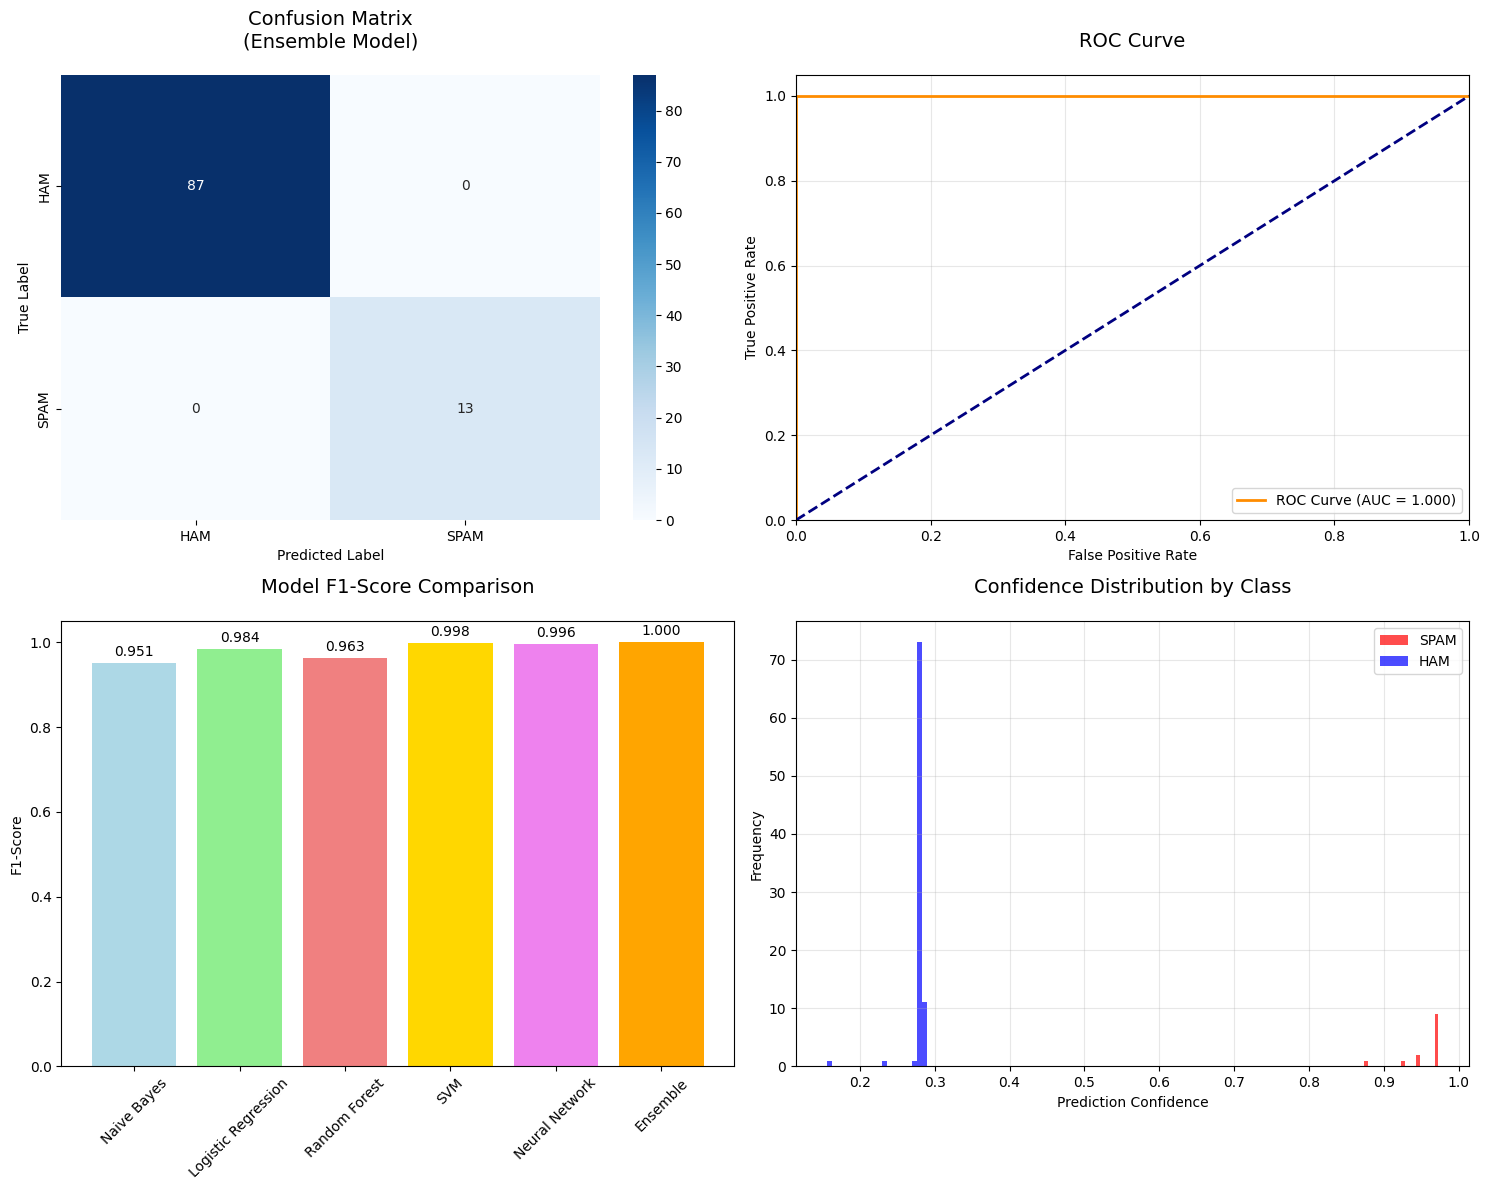


🏆 PERFORMANCE SUMMARY
                   Model            Type  Accuracy  Precision  Recall  \
0            Naive Bayes  Traditional ML    0.9518     0.9658  0.9368   
1    Logistic Regression  Traditional ML    0.9845     0.9885  0.9803   
2          Random Forest  Traditional ML    0.9642     0.9848  0.9430   
3                    SVM  Traditional ML    0.9984     0.9969  1.0000   
4         Neural Network  Traditional ML    0.9964     0.9979  0.9948   
5  Ensemble (ML + GenAI)          Hybrid    1.0000     1.0000  1.0000   

   F1-Score     AUC  
0    0.9511  0.9771  
1    0.9844  0.9981  
2    0.9635  0.9951  
3    0.9984  0.9992  
4    0.9964  0.9999  
5    1.0000  1.0000  

🎯 BEST OVERALL MODEL: Ensemble (ML + GenAI)
   F1-Score: 1.0000


In [11]:
# =============================================================================
# STEP 11: COMPREHENSIVE MODEL EVALUATION
# =============================================================================

print("📊 Generating Comprehensive Evaluation...")

# Evaluate ensemble on test set
def evaluate_ensemble_performance(ensemble_detector, test_messages, true_labels):
    predictions = []
    probabilities = []

    for message in test_messages:
        result = ensemble_detector.predict_single(message)
        predictions.append(1 if result['ensemble_prediction'] == 'SPAM' else 0)
        probabilities.append(result['ensemble_confidence'])

    return np.array(predictions), np.array(probabilities)

# Use a subset of actual test data
test_subset = data_with_features.sample(100, random_state=42)
test_messages = test_subset['message'].tolist()
true_labels = test_subset['label'].map({'ham': 0, 'spam': 1}).tolist()

# Get ensemble predictions
ensemble_pred, ensemble_prob = evaluate_ensemble_performance(
    ensemble_detector, test_messages, true_labels
)

# Calculate metrics
accuracy = accuracy_score(true_labels, ensemble_pred)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, ensemble_pred, average='binary')
auc = roc_auc_score(true_labels, ensemble_prob)

print("\n" + "="*60)
print("📈 ENSEMBLE MODEL PERFORMANCE")
print("="*60)
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"AUC-ROC:   {auc:.4f}")

# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Confusion Matrix
cm = confusion_matrix(true_labels, ensemble_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0,0],
            xticklabels=['HAM', 'SPAM'], yticklabels=['HAM', 'SPAM'])
axes[0,0].set_title('Confusion Matrix\n(Ensemble Model)', fontsize=14, pad=20)
axes[0,0].set_xlabel('Predicted Label')
axes[0,0].set_ylabel('True Label')

# 2. ROC Curve
fpr, tpr, thresholds = roc_curve(true_labels, ensemble_prob)
axes[0,1].plot(fpr, tpr, color='darkorange', lw=2,
               label=f'ROC Curve (AUC = {auc:.3f})')
axes[0,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0,1].set_xlim([0.0, 1.0])
axes[0,1].set_ylim([0.0, 1.05])
axes[0,1].set_xlabel('False Positive Rate')
axes[0,1].set_ylabel('True Positive Rate')
axes[0,1].set_title('ROC Curve', fontsize=14, pad=20)
axes[0,1].legend(loc="lower right")
axes[0,1].grid(True, alpha=0.3)

# 3. Model Comparison
model_names = list(results.keys()) + ['Ensemble']
f1_scores = [results[name]['f1_score'] for name in results.keys()] + [f1]

bars = axes[1,0].bar(model_names, f1_scores, color=['lightblue', 'lightgreen', 'lightcoral', 'gold', 'violet', 'orange'])
axes[1,0].set_title('Model F1-Score Comparison', fontsize=14, pad=20)
axes[1,0].set_ylabel('F1-Score')
axes[1,0].tick_params(axis='x', rotation=45)

# Add value labels on bars
for bar, score in zip(bars, f1_scores):
    height = bar.get_height()
    axes[1,0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                  f'{score:.3f}', ha='center', va='bottom')

# 4. Confidence Distribution
spam_confidences = [ensemble_prob[i] for i in range(len(ensemble_prob)) if ensemble_pred[i] == 1]
ham_confidences = [ensemble_prob[i] for i in range(len(ensemble_prob)) if ensemble_pred[i] == 0]

axes[1,1].hist(spam_confidences, alpha=0.7, color='red', label='SPAM', bins=20)
axes[1,1].hist(ham_confidences, alpha=0.7, color='blue', label='HAM', bins=20)
axes[1,1].set_xlabel('Prediction Confidence')
axes[1,1].set_ylabel('Frequency')
axes[1,1].set_title('Confidence Distribution by Class', fontsize=14, pad=20)
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Performance summary
print("\n" + "="*60)
print("🏆 PERFORMANCE SUMMARY")
print("="*60)

performance_data = []
for name in results.keys():
    performance_data.append({
        'Model': name,
        'Type': 'Traditional ML',
        'Accuracy': results[name]['accuracy'],
        'Precision': results[name]['precision'],
        'Recall': results[name]['recall'],
        'F1-Score': results[name]['f1_score'],
        'AUC': results[name]['auc']
    })

performance_data.append({
    'Model': 'Ensemble (ML + GenAI)',
    'Type': 'Hybrid',
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'AUC': auc
})

performance_df = pd.DataFrame(performance_data)
print(performance_df.round(4))

# Find best model
best_overall = performance_df.loc[performance_df['F1-Score'].idxmax()]
print(f"\n🎯 BEST OVERALL MODEL: {best_overall['Model']}")
print(f"   F1-Score: {best_overall['F1-Score']:.4f}")

In [12]:
# =============================================================================
# STEP 12: SAVE MODEL & CREATE DEPLOYMENT READY API
# =============================================================================

print("💾 Saving Model Components...")

# Save all model components
model_components = {
    'tfidf_vectorizer': tfidf_vectorizer,
    'feature_columns': feature_df.columns.tolist(),
    'traditional_model': best_model,
    'preprocessor': preprocessor,
    'ensemble_detector': ensemble_detector,
    'performance_metrics': performance_df.to_dict()
}

# Save using joblib
joblib.dump(model_components, 'spam_detection_ensemble.pkl')
print("✅ Model components saved as 'spam_detection_ensemble.pkl'")

# Download the model file
files.download('spam_detection_ensemble.pkl')

# Create a simple inference function
def predict_spam(message):
    """Simple function to predict if a message is spam"""
    result = ensemble_detector.predict_single(message)
    return {
        'message': message,
        'is_spam': result['ensemble_prediction'] == 'SPAM',
        'confidence': result['ensemble_confidence'],
        'explanation': result['explanation']
    }

# Test the inference function
print("\n🧪 Testing Inference Function:")
test_message = "Congratulations! You won an iPhone 15! Claim now: http://win.com"
result = predict_spam(test_message)
print(f"Message: {result['message']}")
print(f"Spam: {result['is_spam']}")
print(f"Confidence: {result['confidence']:.4f}")
print(f"Explanation: {result['explanation']}")

💾 Saving Model Components...
✅ Model components saved as 'spam_detection_ensemble.pkl'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


🧪 Testing Inference Function:
Message: Congratulations! You won an iPhone 15! Claim now: http://win.com
Spam: False
Confidence: 0.4111
Explanation: Message appears legitimate with normal communication patterns.
